# Step1 :Install and Import Required Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import pickle


 # Step2:Load the Dataset

In [2]:
df = pd.read_csv("dataset.csv")
df.dropna(inplace=True)   # Replace with actual dataset path
df.head()

,Unnamed: 0,car_name,brand,model,vehicle_age,km_driven,seller_type,fuel_type,transmission_type,mileage,engine,max_power,seats,selling_price
0,0,Maruti Alto,Maruti,Alto,9,120000,Individual,Petrol,Manual,19.70,796,46.30,5,120000
1,1,Hyundai Grand,Hyundai,Grand,5,20000,Individual,Petrol,Manual,18.90,1197,82.00,5,550000
2,2,Hyundai i20,Hyundai,i20,11,60000,Individual,Petrol,Manual,17.00,1197,80.00,5,215000
3,3,Maruti Alto,Maruti,Alto,9,37000,Individual,Petrol,Manual,20.92,998,67.10,5,226000
4,4,Ford Ecosport,Ford,Ecosport,6,30000,Dealer,Diesel,Manual,22.77,1498,98.59,5,570000


# Step3:Data Preprocessing
Convert 'Vehicle Year' to 'Car_Age'

In [3]:

if 'vehicle_age' in df.columns:
    df['Car_Age'] = df['vehicle_age']

if 'mileage' in df.columns and df['mileage'].dtype == 'object':
    df['mileage'] = df['mileage'].astype(str).str.replace(' kmpl', '', regex=True).astype(float)

if 'engine' in df.columns and df['engine'].dtype == 'object':
    df['engine'] = df['engine'].astype(str).str.replace(' CC', '', regex=True).astype(float)

if 'max_power' in df.columns and df['max_power'].dtype == 'object':
    df['max_power'] = df['max_power'].astype(str).str.replace(' bhp', '', regex=True).astype(float)

# Consider imputation instead of dropping all NaNs
df.dropna(inplace=True)  


Removing outliers in numerical columns

In [4]:
def remove_outliers(df, column):
    if column in df.columns and np.issubdtype(df[column].dtype, np.number):  # Ensure it's numeric
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]  # Keep only in-range values
    return df

num_cols = ['km_driven', 'mileage', 'engine', 'max_power', 'seats', 'selling_price']
for col in num_cols:
    if col in df.columns and np.issubdtype(df[col].dtype, np.number):  # Double-check column existence
        df = remove_outliers(df, col)


Define target and features

In [5]:
if 'selling_price' in df.columns:
    y = df['selling_price']
    X = df.drop(columns=['selling_price', 'Unnamed: 0', 'car_name', 'brand', 'model'], errors='ignore')


Ensure X remains a DataFrame

In [6]:
X = pd.DataFrame(X)

In [7]:
categorical_features = [col for col in ['fuel_type', 'seller_type', 'transmission_type'] if col in X.columns]
numerical_features = [col for col in ['Car_Age', 'km_driven', 'mileage', 'engine', 'max_power', 'seats'] if col in X.columns]

Preprocessing for categorical data

In [8]:
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')


Preprocessing for numerical data

In [9]:
numerical_transformer = StandardScaler()

Column Transformer

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Ensure features exist before proceeding

In [11]:
if not numerical_features and not categorical_features:
    print("Warning: No valid features found after preprocessing! Check dataset preprocessing steps.")
    print("Remaining columns in X:", X.columns.tolist())

    # Option 1: Raise an error if the dataset truly has no valid features
    if X.shape[1] == 0:
        raise ValueError("Dataset preprocessing removed all features. Check missing values and outlier handling.")

    # Option 2: Automatically select any remaining features (fallback)
    numerical_features = [col for col in X.columns if np.issubdtype(X[col].dtype, np.number)]
    categorical_features = [col for col in X.columns if X[col].dtype == 'object']

    print("Updated Numerical Features:", numerical_features)
    print("Updated Categorical Features:", categorical_features)

    # If still no valid features, raise an error
    if not numerical_features and not categorical_features:
        raise ValueError("No usable features found even after fallback. Please review preprocessing steps.")


## Step 4: Feature Selection

In [12]:
if X.shape[1] == 0:
    raise ValueError(" No features left in X for preprocessing! Check previous steps.")

X_processed = preprocessor.fit_transform(X)

print("X_processed shape:", X_processed.shape)  


X_processed shape: (11184, 12)


Ensure the preprocessor has fitted components

In [13]:
# Debug Step 1: Print X shape before preprocessing
print("Original X shape:", X.shape)

# Debug Step 2: Print column names of X
print("Columns in X:", X.columns.tolist())

# Debug Step 3: Check which numerical features exist in X
valid_numerical_features = [col for col in numerical_features if col in X.columns]
print("Valid numerical features:", valid_numerical_features)

# Debug Step 4: Check which categorical features exist in X
valid_categorical_features = [col for col in categorical_features if col in X.columns]
print("Valid categorical features:", valid_categorical_features)

# Debug Step 5: If both feature lists are empty, print a warning
if not valid_numerical_features and not valid_categorical_features:
    raise ValueError("No valid numerical or categorical features found in X. Check data preprocessing.")

# Debug Step 6: Recreate the preprocessor using only valid features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, valid_numerical_features),
        ('cat', categorical_transformer, valid_categorical_features)
    ]
)

# Debug Step 7: Apply preprocessing again
X_processed = preprocessor.fit_transform(X)

# Debug Step 8: Extract feature names
feature_names = preprocessor.get_feature_names_out()
print("Feature names after transformation:", feature_names)

# Convert processed data into DataFrame
X_df = pd.DataFrame(X_processed, columns=feature_names)
print("X_df shape:", X_df.shape)
print("X_df first rows:\n", X_df.head())


Original X shape: (11184, 10)
Columns in X: ['vehicle_age', 'km_driven', 'seller_type', 'fuel_type', 'transmission_type', 'mileage', 'engine', 'max_power', 'seats', 'Car_Age']
Valid numerical features: ['Car_Age', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']
Valid categorical features: ['fuel_type', 'seller_type', 'transmission_type']
Feature names after transformation: ['num__Car_Age' 'num__km_driven' 'num__mileage' 'num__engine'
 'num__max_power' 'num__seats' 'cat__fuel_type_Diesel'
 'cat__fuel_type_LPG' 'cat__fuel_type_Petrol'
 'cat__seller_type_Individual' 'cat__seller_type_Trustmark Dealer'
 'cat__transmission_type_Manual']
X_df shape: (11184, 12)
X_df first rows:
    num__Car_Age  num__km_driven  num__mileage  num__engine  num__max_power  \
0      1.012592        2.582079     -0.392947    -2.116466       -2.002752   
1     -0.321035       -1.076510     -0.632747    -0.255738       -0.141181   
2      1.679406        0.386925     -1.202272    -0.255738       -0.245470  

In [14]:
# Ensure k is not greater than available features
k_value = min(5, X_df.shape[1])

# Apply feature selection
selector = SelectKBest(score_func=f_regression, k=k_value)
X_selected = selector.fit_transform(X_df, y)

print("X_selected shape:", X_selected.shape)


X_selected shape: (11184, 5)


# Step5:Train-Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


## Step 6: Train Linear Regression Model

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Model Performance:")
print(f"MAE: {mae_lr:.2f}")
print(f"MSE: {mse_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R² Score: {r2_lr:.2f}")

Linear Regression Model Performance:
MAE: 92924.85
MSE: 13860415547.55
RMSE: 117730.27
R² Score: 0.72


## Step 7: Train optimised random forest model

In [17]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
rf_best = grid_search.best_estimator_
y_pred_rf = rf_best.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Model Performance:")
print(f"MAE: {mae_rf:.2f}")
print(f"MSE: {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")


Random Forest Model Performance:
MAE: 63084.51
MSE: 6960007897.70
RMSE: 83426.66
R² Score: 0.86


 Feature Importance Analysis

In [18]:
# Ensure feature_names matches X_train shape
if isinstance(X_train, np.ndarray):
    if len(feature_names) != X_train.shape[1]:  # Mismatch detected
        print(f"Feature name count ({len(feature_names)}) does not match X_train columns ({X_train.shape[1]}). Adjusting...")
        feature_names = feature_names[:X_train.shape[1]]  # Trim feature names

    X_train_df = pd.DataFrame(X_train, columns=feature_names)  # Convert to DataFrame

# Now get feature importances
importances = rf_best.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train_df.columns, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importance_df)


Feature name count (12) does not match X_train columns (5). Adjusting...
          Feature  Importance
3     num__engine    0.475471
0    num__Car_Age    0.454675
2    num__mileage    0.036003
1  num__km_driven    0.030816
4  num__max_power    0.003034


## Step 8: Visualize Model Performance

12052    750000
10095    165000
10469    365000
7033     290000
4297     520000
Name: selling_price, dtype: int64 [993926.69953943 234710.33750604 386870.4749994  259263.23770285
 527583.52835186]


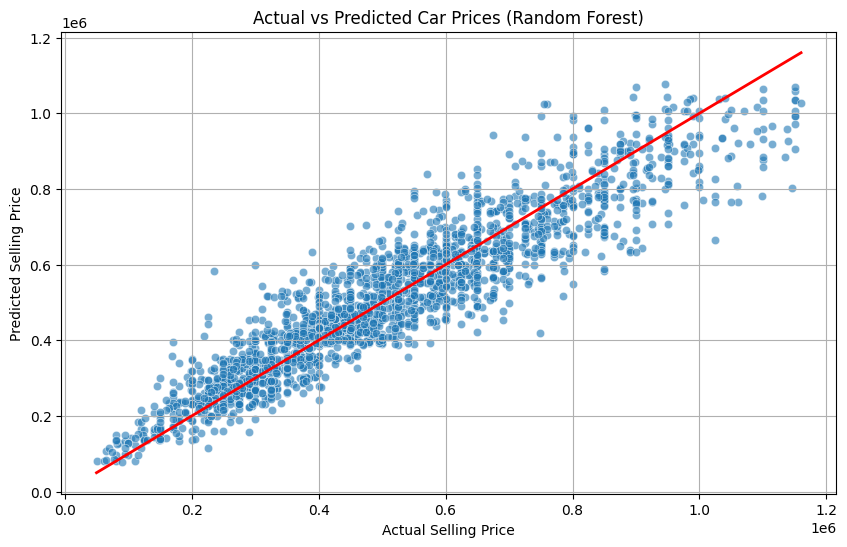

In [19]:
print(y_test[:5], y_pred_rf[:5])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Actual vs Predicted Car Prices (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # 45-degree reference line
plt.grid(True)  # Add a grid for better readability
plt.show(block=True)

## Step 8: Save the Model

In [20]:
best_model = rf_best if r2_rf > r2_lr else lr
model_name = "random_forest_car_price_model.pkl" if r2_rf > r2_lr else "linear_regression_car_price_model.pkl"

with open(model_name, "wb") as file:
    pickle.dump(best_model, file)

print(f"Best model saved as {model_name}")

Best model saved as random_forest_car_price_model.pkl
